In [1]:
import pandas as pd
import numpy as np
import os, glob
import pickle
import scanpy as sc

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

#from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import load_motifs
from pyscenic.prune import df2regulons
from pyscenic.aucell import aucell

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

from collections import OrderedDict
from collections import Counter

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/pmedseq-data/sarthak/soft

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
os.chdir('/opt/megaseq-data/sarthak/projects/MMRF/')
ITERS = 100 -1
MOTIFS_CUT = 0.80
GENES_CUT = 0.90

In [3]:
# Load motifs
motifs = []
for i in range(0, ITERS+1):
    motifs.append(load_motifs(f'scenic_MY_reduced/NB_run{i}_motifs.csv')) ## here

# Collect regulons
regulons = []
for regulons_l in map(df2regulons, motifs):
    single = None
    for r in regulons_l:
        ks = []
        for k, v in r.gene2weight.items():
            ks += [k]
        single = pd.concat([single, pd.DataFrame({r.name: ks})], axis=1)
    regulons.append(single.fillna(''))

# Get regulons identified at least 80% in all runs
columns = Counter([
    e for l in map(lambda x: list(x.columns), regulons) for e in l
])
columns = [e for e in columns if columns[e] > (ITERS+1)*MOTIFS_CUT] ## here


Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns saved: []
Create regulons from a dataframe of enriched features.
Additional columns sa

In [4]:
len(columns)

22

In [5]:
# Get target genes (also identified at least 80% of experiments) of stable regulons
from ctxcore.genesig import Regulon
stable_regulons = None
regulons_to_save = []
for c in columns:

    targets = []
    gene2weight = {}
    gene2occurence = {}

    for r in regulons:
        if c in r.columns:
           targets.extend(filter(lambda x: x != '', r[c]))

    targets = Counter(targets)
    targets_save = targets.copy()
    targets = [e for e in targets if targets[e] > (ITERS+1)*GENES_CUT] ### here

    stable_regulons = pd.concat([
        stable_regulons, pd.DataFrame({c: targets})
    ], axis=1) 

    for t in targets:
        gene2weight[t] = 1.0
        gene2occurence[t] = targets_save[t]
        
    try:
        regulons_to_save.append(Regulon(name=c, gene2weight=gene2weight, gene2occurrence=gene2occurence, transcription_factor=c[:-3]))
    except:
        pass

In [ ]:
# regulons_to_save[10].gene2occurrence
# res = {key : val for key, val in regulons_to_save[10].gene2occurrence.items()
#                    if val < 90}
# res.keys()


In [6]:
regulons_to_save

[Regulon(name='ATF3(+)', gene2weight=frozendict.frozendict({'ZNF331': 1.0, 'ATF3': 1.0, 'NR4A1': 1.0, 'NR4A2': 1.0}), gene2occurrence=frozendict.frozendict({'ZNF331': 100, 'ATF3': 98, 'NR4A1': 91, 'NR4A2': 94}), transcription_factor='ATF3', context=frozenset(), score=0.0, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation=''),
 Regulon(name='BRCA1(+)', gene2weight=frozendict.frozendict({'SLF1': 1.0, 'ANLN': 1.0, 'SLC12A2': 1.0, 'STIL': 1.0, 'AHI1': 1.0, 'USP45': 1.0, 'C5orf30': 1.0, 'MSRB3': 1.0, 'EXO1': 1.0, 'PRKACB': 1.0, 'DACH1': 1.0, 'SSX2IP': 1.0, 'GOLIM4': 1.0, 'UCHL5': 1.0, 'PDS5B': 1.0, 'MAD2L1': 1.0, 'SCN9A': 1.0, 'RPA2': 1.0, 'MIS18BP1': 1.0, 'ZNF549': 1.0, 'DIAPH3': 1.0, 'MTX2': 1.0, 'ADK': 1.0, 'LMNB1': 1.0, 'VRK1': 1.0, 'CACYBP': 1.0, 'CISD1': 1.0, 'GEN1': 1.0, 'MPC2': 1.0, 'MKI67': 1.0, 'RTKN2': 1.0, 'FANCL': 1.0, 'KIF2A': 1.0, 'CEP44': 1.0, 'CETN3': 1.0, 'PSIP1': 1.0, 'MGA': 1.0, 'CENPV': 1.0, 'PRDM5': 1.0, 'GSTCD': 1.0, 'OXCT1': 1.0, 'SPATS2L': 1.0, 'R

In [7]:
len(regulons_to_save)

15

In [8]:
cols = ['Regulon', 'Target']
lst = []
for i in range(0, len(regulons_to_save)):
    lst.append([regulons_to_save[i].name, regulons_to_save[i].gene2weight.keys() ])
df = pd.DataFrame(lst, columns=cols)
df.to_csv('outs/' + str(int(GENES_CUT*100)) + '/MYRED_regulon_target.csv')

In [9]:
adata = sc.read_h5ad("objects/anndata_4000_42266Cells_MY_REDUCE_counts.h5ad") ### here
auc_mtx = aucell(adata.to_df(), regulons_to_save) #normalize=True
rss = regulon_specificity_scores(auc_mtx, adata.obs.subcluster_V03072023) ### here

In [10]:
auc_mtx.to_csv('outs/' + str(int(GENES_CUT*100)) +'/MYRED_auc.csv')

In [11]:
adata

AnnData object with n_obs × n_vars = 42266 × 4000
    obs: 'BASELINE_WITH_VALID_FOLLOWUPS', 'BA_IMAGEINTERPRE', 'BA_LYTICLESIONS', 'BA_OFLYTICLESION', 'BA_TYPEOFBONEASS', 'BONE_DAYOFCOLLECT', 'BONE_DOESTHEPCRESU', 'BONE_PC2', 'BONE_PC3', 'BONE_PC5', 'BONE_PERCENTOFPLAS', 'BONE_RANGEHIGH', 'BONE_RANGEHIGH2', 'BONE_RANGEHIGH3', 'BONE_RANGEHIGH4', 'BONE_RANGEHIGH6', 'BONE_RANGELOW', 'BONE_RANGELOW2', 'BONE_RANGELOW3', 'BONE_RANGELOW4', 'BONE_RANGELOW6', 'BONE_REASONFORPROC', 'BONE_REPORTEDBYCYT', 'Batch', 'DF_doublet_score', 'DF_pred_dbl', 'D_IM_CD117_PC_PERCENT', 'D_IM_CD138_PC_PERCENT', 'D_IM_CD13_PC_PERCENT', 'D_IM_CD19_PC_PERCENT', 'D_IM_CD20_PC_PERCENT', 'D_IM_CD27_PC_PERCENT', 'D_IM_CD28_PC_PERCENT', 'D_IM_CD319_PC_PERCENT', 'D_IM_CD33_PC_PERCENT', 'D_IM_CD38_DESCRIPTION', 'D_IM_CD38_PC_PERCENT', 'D_IM_CD45_DESCRIPTION', 'D_IM_CD45_PC_PERCENT', 'D_IM_CD52_PC_PERCENT', 'D_IM_CD56_DESCRIPTION', 'D_IM_CD56_PC_PERCENT', 'D_IM_CD81_PC_PERCENT', 'D_IM_FGFR3_PC_PERCENT', 'D_IM_FLOWCYT_PCT_

In [12]:
#Generate a Z-score for each regulon to enable comparison between regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

In [13]:
# add Z score of regulons as metadata
for ob in range(auc_mtx.shape[1]):
    ob_name = auc_mtx_Z.columns[ob]
    adata.obs[ob_name] = auc_mtx_Z[ob_name]

In [14]:

group = 'subcluster_V03072023' ## here
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.endswith('(+)'), signature_column_names))
df_scores = df_obs[signature_column_names + [group]]

df_results = (df_scores.groupby(by=group).mean() ).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
#df_results[(df_results.Z >= 0)].sort_values('Z', ascending=False)
df_heatmap = pd.pivot_table(data=df_results.sort_values('Z'),
                        index=group, columns='regulon', values='Z')

/tmp/ipykernel_3189257/4131402052.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_results = (df_scores.groupby(by=group).mean() ).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})


In [15]:
cats = sorted(list(set(adata.obs['subcluster_V03072023'])))
cats


['Myeloid.12', 'Myeloid.2', 'Myeloid.5', 'Myeloid.8']

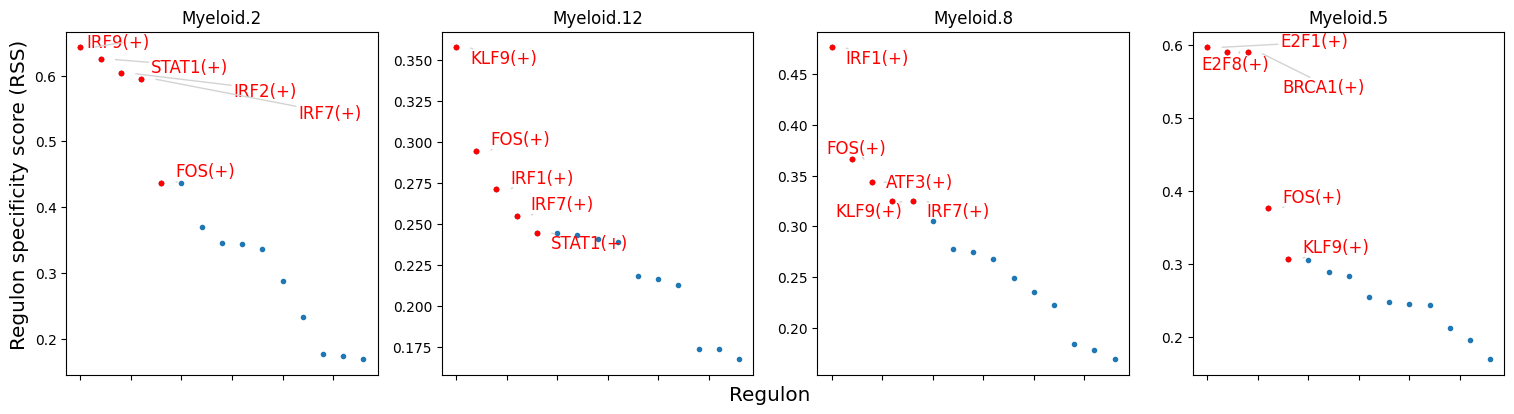

In [16]:
cats = [ 'Myeloid.2', 'Myeloid.12', 'Myeloid.8', 'Myeloid.5']
from adjustText import adjust_text
#cats = sorted(list(set(adata.obs.seurat_clusters))) ## here
#cats = [0,1,3,7,8,9,10,11]
fig = plt.figure(figsize=(15, 4))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(1,4,num)
    plot_rss(rss, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig(('outs/' + str(int(GENES_CUT*100)) +'/seurat_cluster_RSS.pdf'), dpi=600, bbox_inches = "tight")
plt.show()

In [17]:
foo = df_heatmap.T
#foo['diff'] = abs(foo['Myeloid.2']-foo['Myeloid.12'])
foo.to_csv('outs/' + str(int(GENES_CUT*100)) +'/MYRED_aucZMean_cluster.csv')
foo

subcluster_V03072023,Myeloid.2,Myeloid.5,Myeloid.8,Myeloid.12
regulon,,,,
ATF3(+),0.034859,-0.260769,0.286636,-0.019483
BRCA1(+),-0.523180,1.319664,-0.627298,-0.421258
E2F1(+),-0.409593,1.045363,-0.478217,-0.391390
E2F7(+),-0.122521,0.269061,-0.094365,-0.100824
E2F8(+),-0.499314,1.289004,-0.633224,-0.409625
ETS1(+),-0.050289,0.076038,0.005641,-0.041476
FOS(+),-0.059199,-0.170063,0.115421,0.436910
FOSL2(+),0.009645,-0.049701,0.007081,0.087771
IKZF2(+),0.001658,0.000080,0.007420,-0.022174


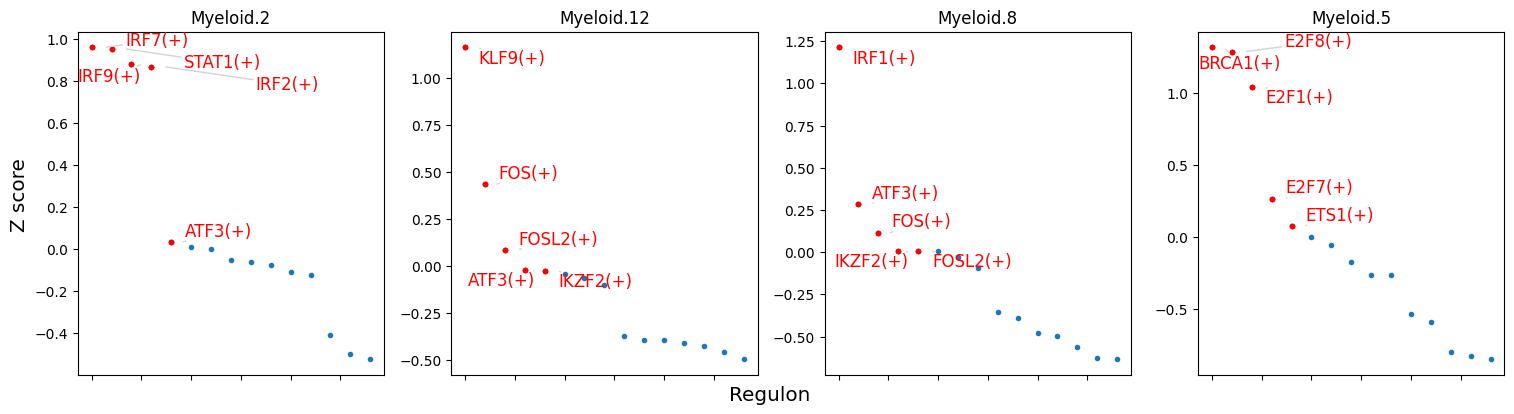

In [18]:
## Plot z score for fibroblast clsuters
from adjustText import adjust_text
#cats = sorted(list(set(adata.obs.seurat_clusters)))
fig = plt.figure(figsize=(15, 4))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=df_heatmap.T[c]
    ax = fig.add_subplot(1,4,num)
    plot_rss(df_heatmap, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Z score', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig(('outs/' + str(int(GENES_CUT*100)) +'/_z_score.pdf'), dpi=600, bbox_inches = "tight")
plt.show()

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/pmedseq-

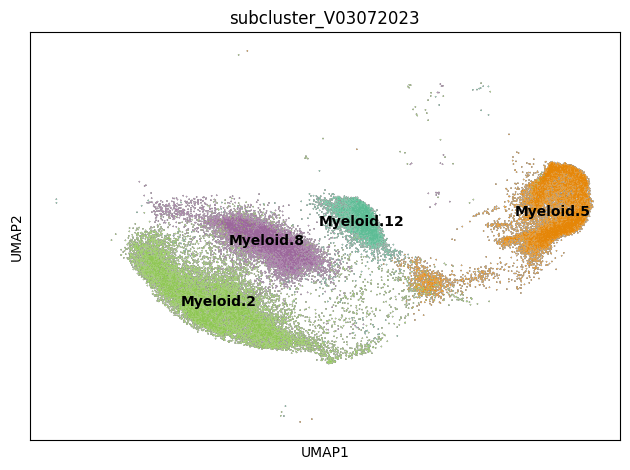

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


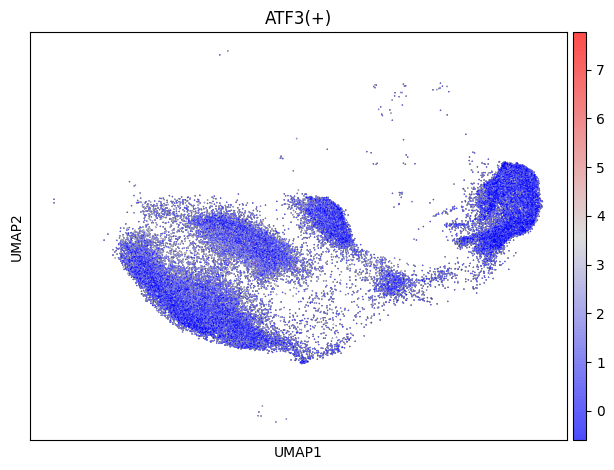

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11

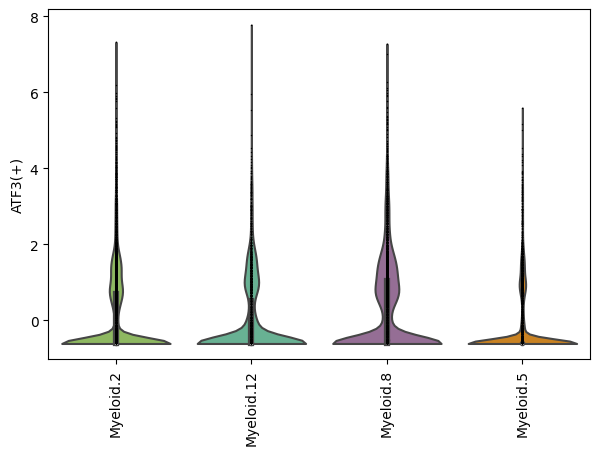

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


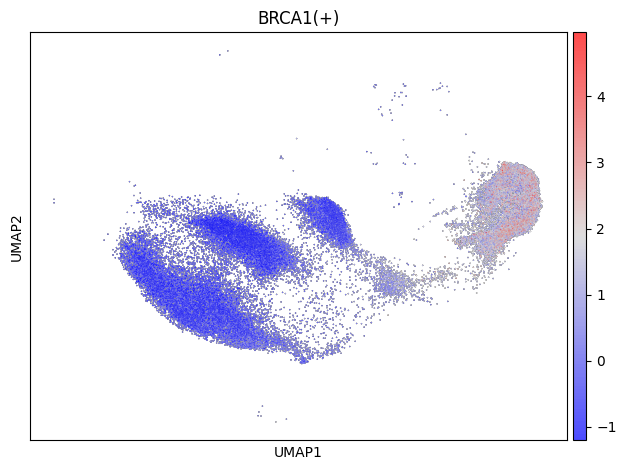

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


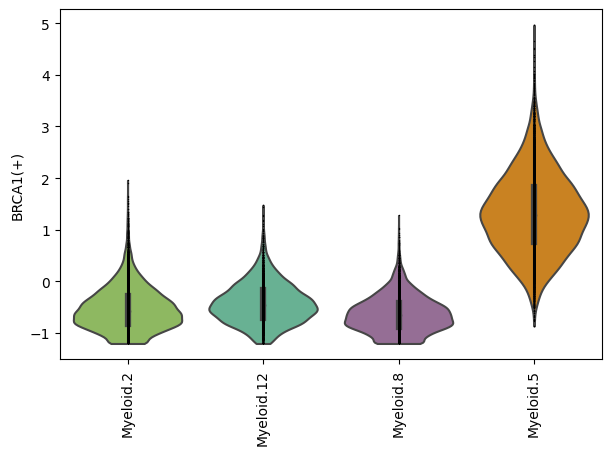

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


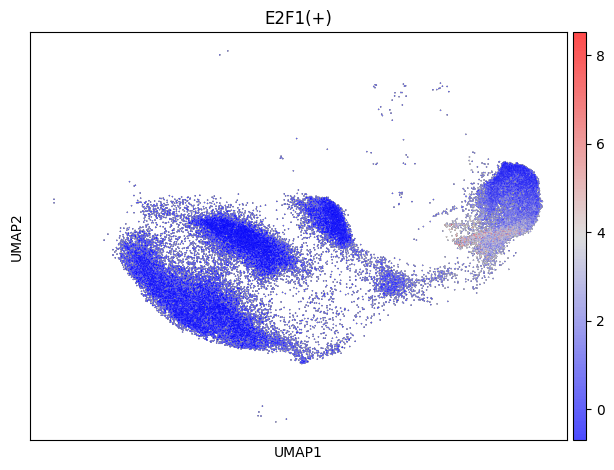

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


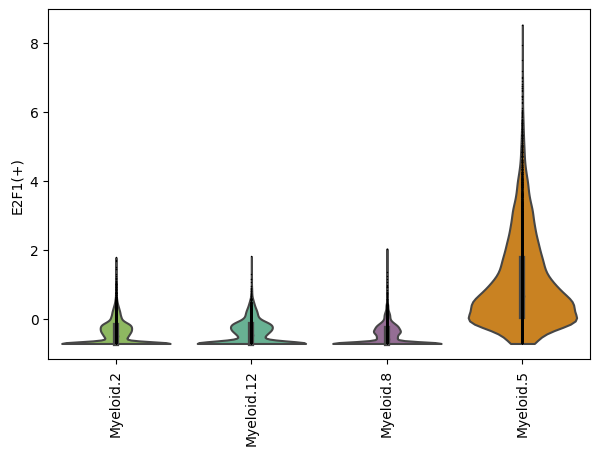

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


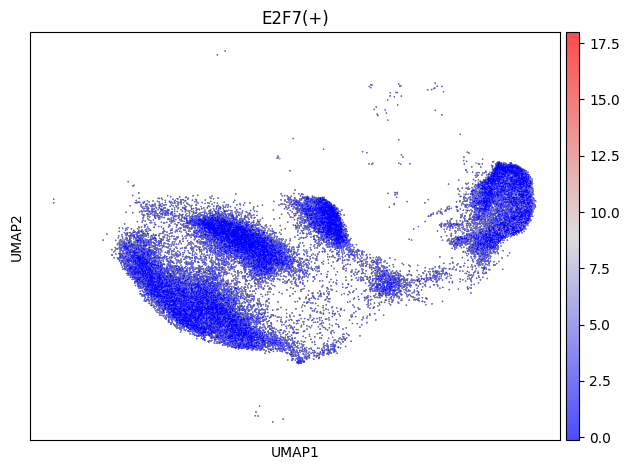

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11

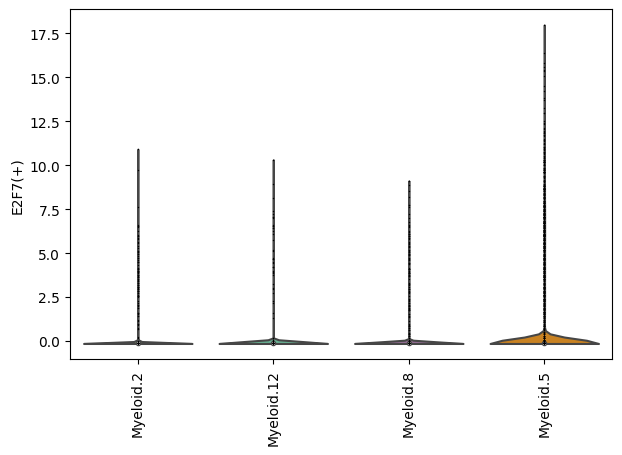

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


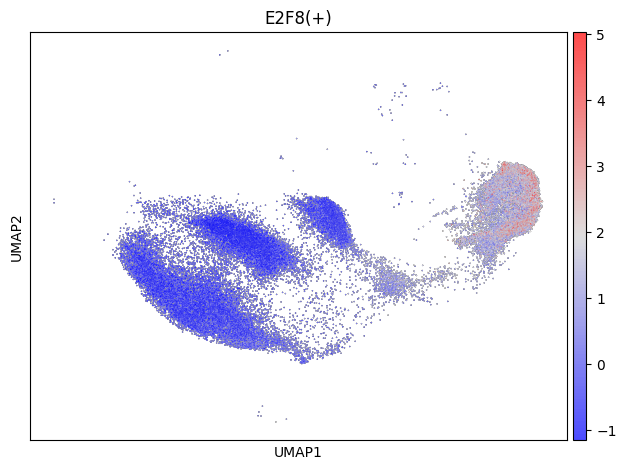

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


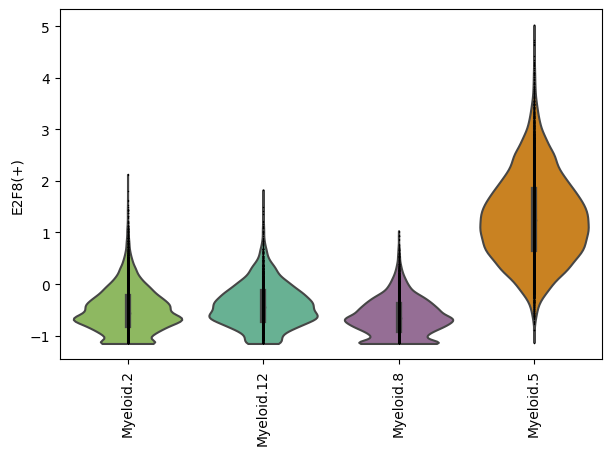

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


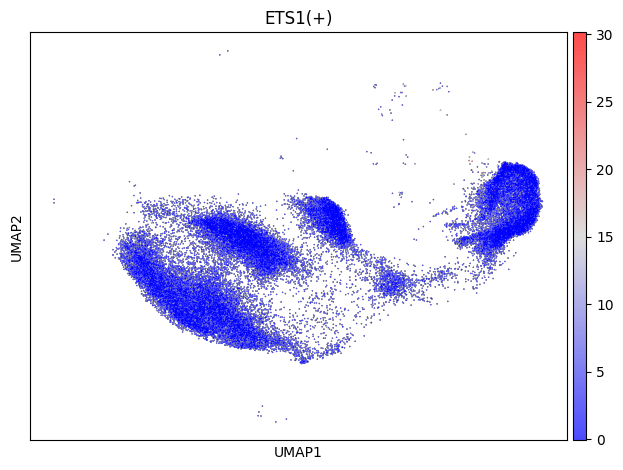

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


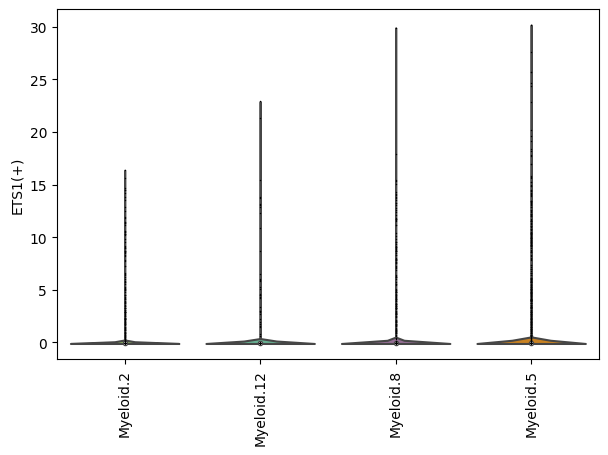

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


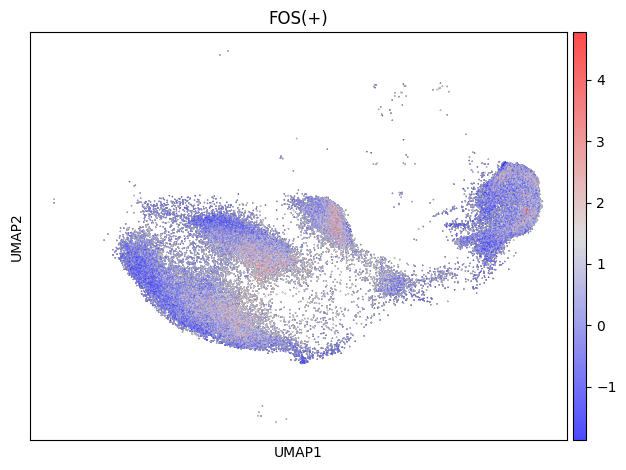

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

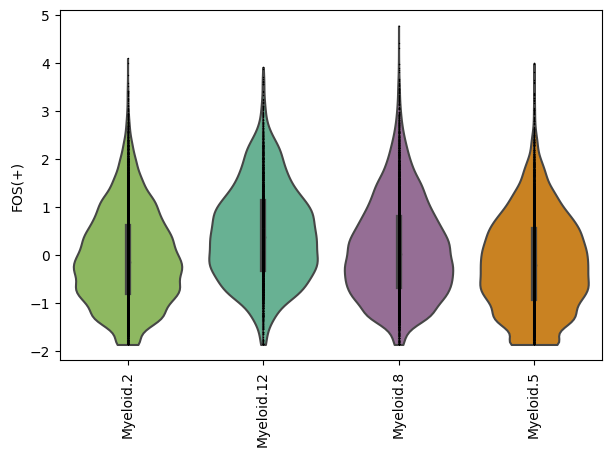

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


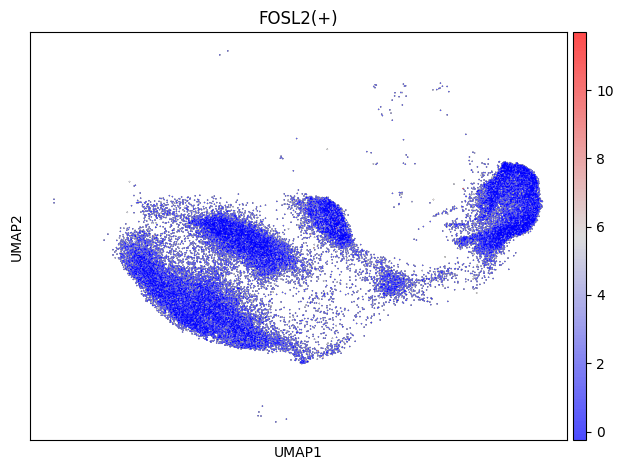

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


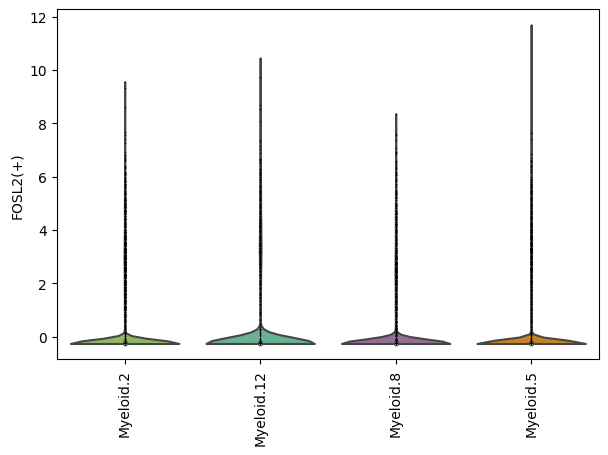

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


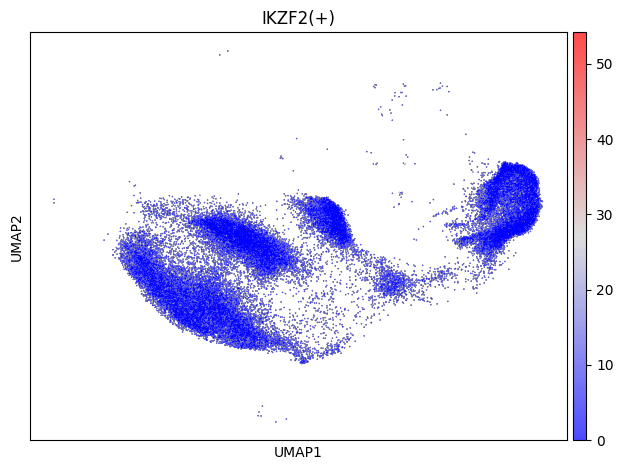

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


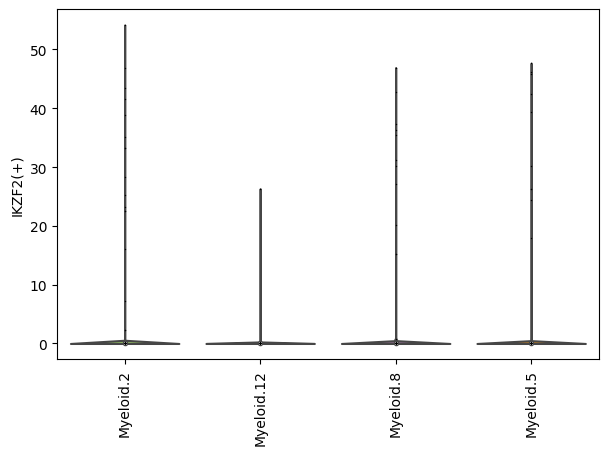

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


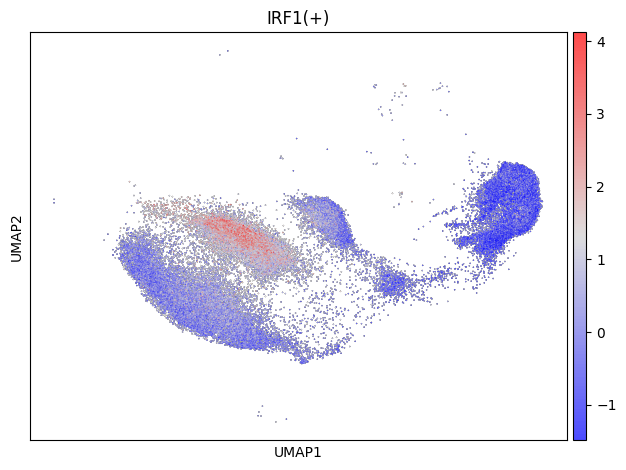

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

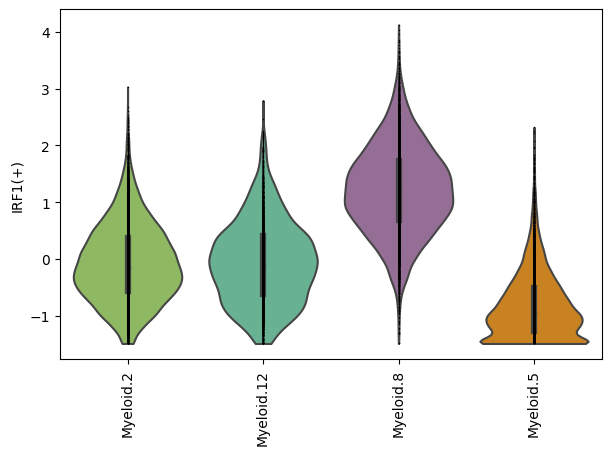

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


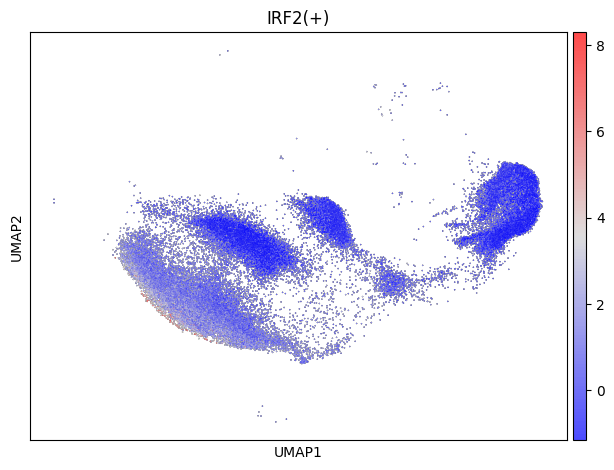

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

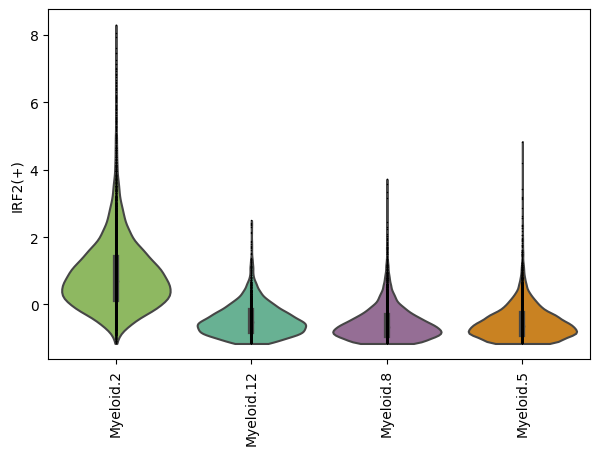

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


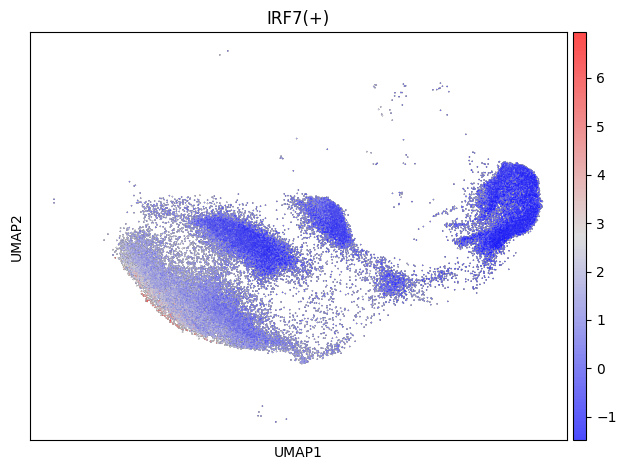

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

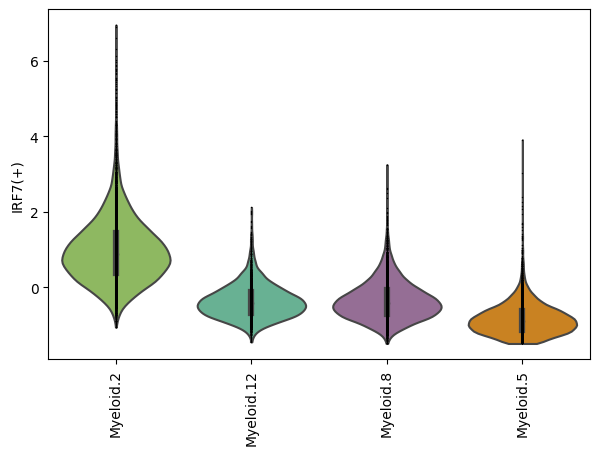

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


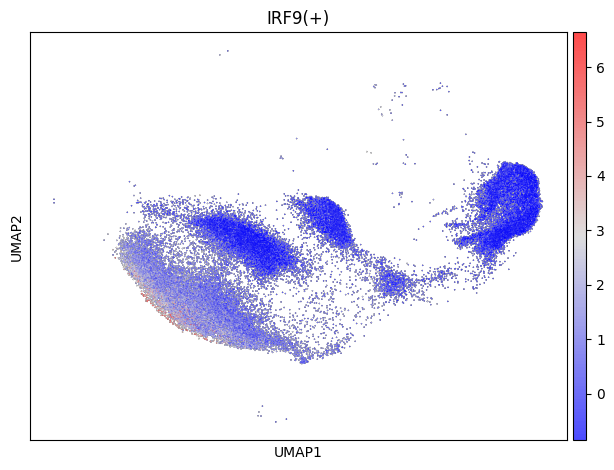

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

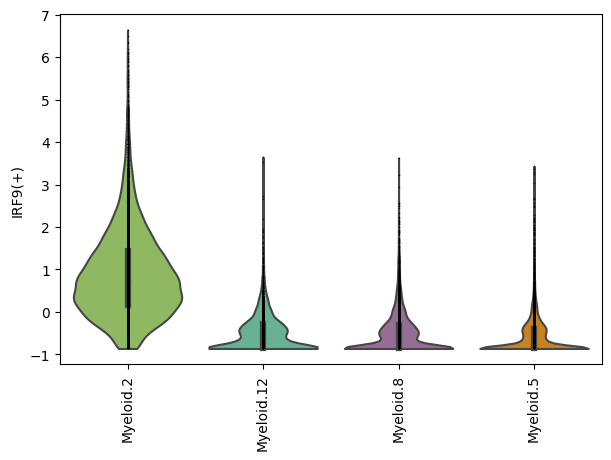

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


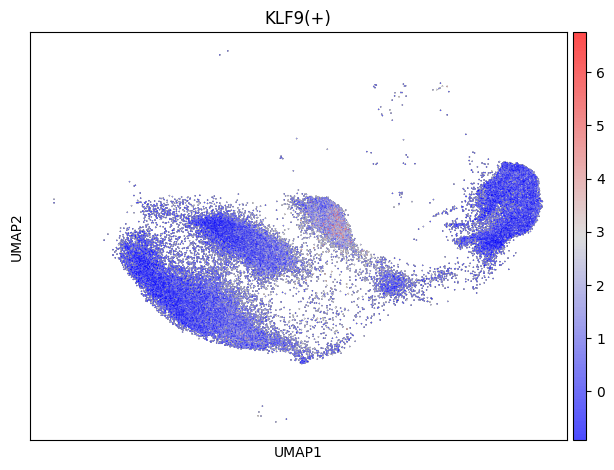

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

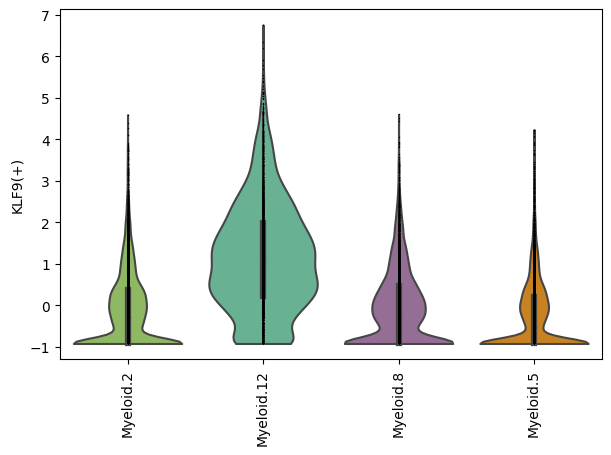

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


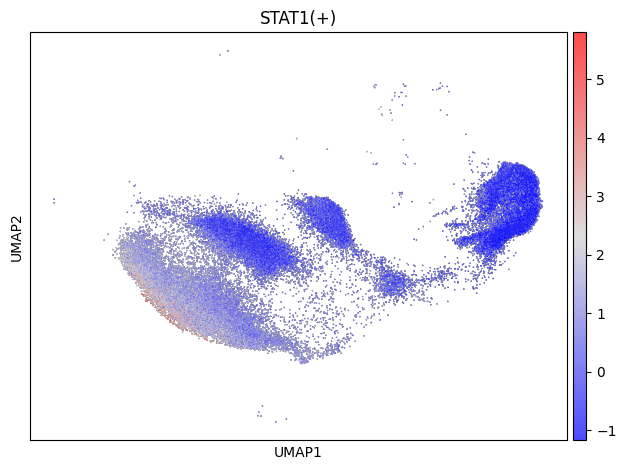

/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/pmedseq-data/sarthak/softwares/anaconda3/envs/pyscenic_new/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

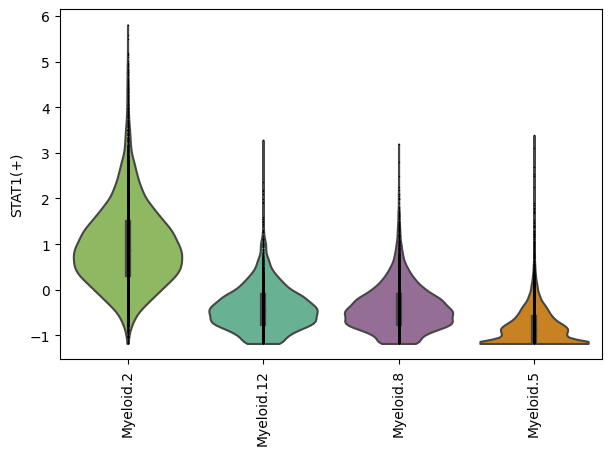

In [19]:
adata.uns['subcluster_V03072023_colors'] = ['#8EC752','#E58606', '#9C679C','#5CBD95' ]
sc.pl.umap(adata, color= 'subcluster_V03072023',  add_outline = True, outline_width= [0.1,0.03], legend_loc= 'on data')
cl_pal = ['#8EC752','#5CBD95', '#9C679C', '#E58606']
for gene in df_heatmap.columns.to_list():
    cmap = mpl.colors.LinearSegmentedColormap.from_list('custom blue', ['#0000FF','#d0d0d0','#FF0000'], N=128)
    sc.pl.umap(adata, color= gene, color_map = cmap, add_outline = True, outline_width= [0.1,0.03], save = 'outs/' + str(int(GENES_CUT*100)) +'/Z_SCANPY_UMAP_' + gene.replace("(+)","") +'.png')
    sc.pl.violin(adata, keys=gene, groupby='subcluster_V03072023', rotation=90, order = cats, inner = 'box', jitter = False, palette = cl_pal, box_width = 30, save = 'outs/' + str(int(GENES_CUT*100)) +'/Z_SCANPY_VLN_' + gene.replace("(+)","") +'.png')
    

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom blue', ['#0000FF','#d0d0d0','#FF0000'], N=128)
gene = 'IRF7(+)'
cl_pal = ['#8EC752','#5CBD95', '#9C679C', '#E58606']
sc.pl.umap(adata, color= gene, color_map = cmap, add_outline = True, outline_width= [0.1,0.03], vmin =-1, vmax = 2)
sc.pl.violin(adata, keys=gene, groupby='subcluster_V03072023', rotation=90, order = cats, inner = 'box', jitter = False, palette = cl_pal, box_width = 30)

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom blue', ['#0000FF','#d0d0d0','#FF0000'], N=128)
gene = 'E2F1(+)'
cl_pal = ['#8EC752','#5CBD95', '#9C679C', '#E58606']
sc.pl.umap(adata, color= gene, color_map = cmap, add_outline = True, outline_width= [0.1,0.03], vmin =-1, vmax = 2.5)
sc.pl.violin(adata, keys=gene, groupby='subcluster_V03072023', rotation=90, order = cats, inner = 'box', jitter = False, palette = cl_pal, box_width = 30)